# Transfer Learning - INFERENCE

## Load Libraries



In [ ]:
import importlib
import sys
import os
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import librosa

import torch
from torch import nn
import torch.optim as optim

from torch.utils import data
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), ".."))

from distiller import apputils
import ai8x

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

kws20 = importlib.import_module("datasets.kws20-horsecough")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix

## PREPARE MODEL FOR EVALUATION MODE

In [ ]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(params)
    return params

ai8x.set_device(device=85, simulate=False, round_avg=False)


# WEIGHTS OF TRAINED MODEL

# checkpoint_dir = "../logs/kws20_original/qat_best.pth.tar"
# mod = importlib.import_module("models.ai85net-kws20-v3")
# model = mod.AI85KWS20Netv3(num_classes=21, num_channels=128, dimensions=(128, 1), bias=False)

checkpoint_dir = "../notebooks/checkpoints/human_others_2/qat_human_others_2_best.pth.tar"
mod = importlib.import_module("models.ai85net-equine-binary")
model = mod.AI85KWS20Netv3(num_classes=2, num_channels=128, dimensions=(128, 1), bias=False)

model, compression_scheduler, optimizer, start_epoch = apputils.load_checkpoint(
            model, checkpoint_dir)



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

model = model.to(device)

num_epochs = 1000

qat_policy = {
    'start_epoch': int(num_epochs/5),
    'weight_bits': 8
    }

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)
# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)
# Model is re-transferred to GPU in case parameters were added
model.to(device)

## PREPARE DATA FOR INFERENCE

In [ ]:
def rescale(audio, min_val=-1,max_val=1):
            sig = audio
            mean = np.average(sig)

            sig = sig-mean # REMOVE DC COMPONENT

            sig_max = np.max(sig)
            sig_min = np.min(sig)

            if sig_max >= np.abs(sig_min):
                sig_scaled = sig/sig_max
            else:
                sig_scaled = sig/np.abs(sig_min)

            return sig_scaled

In [ ]:
class_paths = {'combined': "../data/KWS_EQUINE/raw/combined/",
              'human_cough': "C:/Users/J_C/Desktop/DATASETS_N/human_cough_v3/",
                # 'human_cough': "../data/KWS_EQUINE/raw/human_cough/",
               'combined_kws': "../data/KWS_EQUINE/raw/__combinedkws/",
               'horse_cough': "../data/KWS_EQUINE/inference/horse_cough/"
}

y_true_train = []
y_pred_train = []

classes = list(class_paths.keys())
time_start = time.time()
with torch.no_grad():
    for class_ix,inf_path in enumerate(list(class_paths.values())):
        files = os.listdir(inf_path)
        file_count = len(files)
        inferences = []
        for counter,f in enumerate(files):
            try:
                print('Class: ',class_ix,'  Remaining: ',(file_count-counter))

                # CONVERT EACH AUDIO FILE TO A 128X128 ARRAY
                data_sq = np.zeros(128)
                data,sr = librosa.load(inf_path+f,sr = 16000)
                data = rescale(audio=data)
                data = librosa.util.fix_length(data,size=int(128*128))
                for index in range(0,len(data),128):
                    data_row = data[index:index+128]
                    data_sq = np.vstack((data_sq,data_row))
                data_sq = data_sq[1:129]
                data_sq = np.asarray(data_sq).astype(np.float32)
                data_sq = data_sq.transpose()
                
                # CONVERT ARRAY TO TENSOR
                data_sq = np.expand_dims(data_sq, axis=0)
                inputs = torch.from_numpy(data_sq)  
                
                ############ INFERENCE SECTION ############
                model.eval()
                inputs = inputs.to(device)
                model_out = model.forward(inputs)
                target_out = torch.argmax(model_out, dim=1)
                class_output = target_out.detach().item()

                # For KWS words
                if class_ix == 2 and class_output == 0: class_output = class_ix
                elif class_ix == 2 and class_output == 1: class_output = 3

                # For Horse Cough
                if class_ix == 3 and class_output == 1: class_output = class_ix
                elif class_ix == 3 and class_output == 0: class_output = 2

                
                y_true_train.append(class_ix)
                y_pred_train.append(class_output)
            except Exception as e:
                print(e)

     #print('\t\t Test Acc: {:.2f}'.format(total_acc))
   

time_end = time.time()

print('Inference Finished in {:2f} seconds'.format(time_end-time_start))

In [ ]:
def plot_confusion(y_true, y_pred, classes):
    cf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred, labels =list(range(len(classes))))
    print(cf_matrix)
    
print (np.shape(y_true_train))
print (np.shape(y_pred_train))
print("\n Inference - Confusion Matrix: ")
plot_confusion(y_true_train, y_pred_train, classes)

## PLOT ROC

model 2 AUC score: 0.9


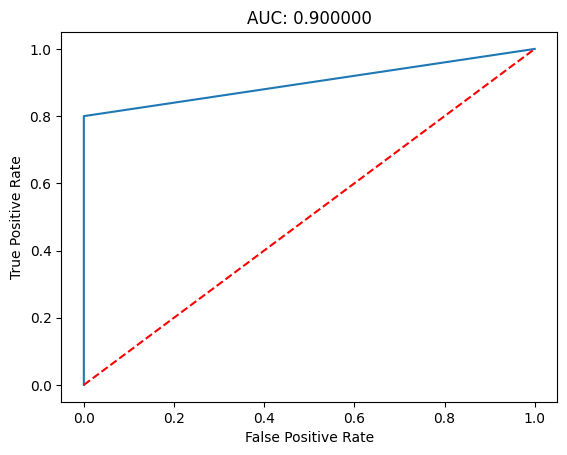

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


classes = ['combined','cough']
y_true_train = [1, 1, 1 ,1 ,1 ,0]
y_pred_train = [1, 1, 1 ,1 ,0 ,0]

plot_roc_curve(y_true_train, y_pred_train)
print(f'model 2 AUC score: {roc_auc_score(y_true_train, y_pred_train)}')

plt.title('AUC: {:2f}'.format(roc_auc_score(y_true_train, y_pred_train)))
plt.savefig('roc.png')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support,PrecisionRecallDisplay
import matplotlib.pyplot as plt

classes = ['combined','cough']
actual = [1, 1, 1 ,1 ,1 ,0]
predicted = [1, 1, 1 ,1 ,0 ,0]

conf_mat_train = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat_train, display_labels = classes)
precision,recall,f1score,_= precision_recall_fscore_support(actual, predicted, average=None)

precision = np.round(precision,2)
recall = np.round(recall,2)
f1score = np.round(f1score,2)

plt.figure(1, layout = 'tight')
stats = 'Precison: ' + str(precision) + '  Recall: ' + str(recall) + '  F1-Score: ' + str(f1score) + '\n'
cm_display.plot(cmap= 'Blues',colorbar=False)
plt.title(stats)
plt.savefig('conf_mat_test.png')


In [ ]:
import numpy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support,PrecisionRecallDisplay
import matplotlib.pyplot as plt
from itertools import cycle

colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
classes = ['combined','cough']
actual = [1, 1, 1 ,1 ,1 ,0]
predicted = [1, 1, 1 ,1 ,0 ,0]


precision = dict()
recall = dict()
average_precision = dict()

_, ax = plt.subplots(figsize=(7, 8))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(len(classes)), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

